In [1]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import pdb

%matplotlib inline

In [2]:
device = "cpu" if torch.cuda.is_available() else "cuda:0" # если у тебя только CPU, то автоматически device = 'cpu'

## Define target density

In [3]:
class Correlated_gaussian():
    '''
    This class defines correlated gaussian target (2d)
    '''
    def __init__(self, mu, covar):
        self.distr = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=covar)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, )) # аргументом должен быть iterable

In [4]:
## Option 1
mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
covar = torch.tensor([[1., 0.95], [0.95, 1.]], device=device, dtype=torch.float32)

# ## Option 2
# mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
# covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

In [5]:
target = Correlated_gaussian(mu, covar)

## Plot samples from the target

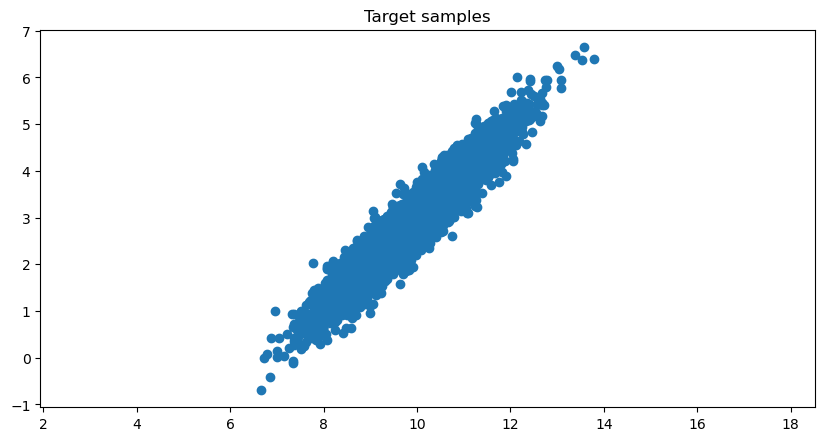

In [6]:
samples = target.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

## Variational inference

Мы выберем простое вариационное распределение: mean-field gaussian

Оно параметризуется двумя векторами -- вектор средних и вектор стандартных отклонений.

In [7]:
# torch.nn.Parameter -- это объект, который далее передается в оптимизатор, по параметрами после производится оптимизация
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

# обрати внимание, что это std_raw. Std должен быть >0, поэтому мы будем оптимизировать "сырой" вектор,
# который каждый раз будем подставлять в экспоненту

# то есть стартовые параметры, mu_param = 0, 0; std = exp(std_param_raw) = 1, 1
std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw],
                            lr=1e-2) # добавляем параметры в оптимайзер
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)


# стандартное нормальное распределение нужно нам для reparametrization trick (будет в статье про VAE)
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [8]:
batch_size = 1000
num_batches = 10000

KL$(q_{\phi}(z)\|p(z)) = \int_z q_{\phi}(z)\log\frac{q_{\phi}(z)}{p(z)} dz = E_{q_{\phi}(z)}\log q_{\phi}(z) - E _{q_{\phi}(z)}\log p(z)$

Оценки мат.ожиданий из формулы выше будем брать методом Монте-Карло, то есть с помощью семплов

In [9]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2)) # это пригодится для reparametrization trick
    
    # Берем семплы из вариационного распределения:
    std = torch.exp(std_param_raw)
    z = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
                                                # случайные ноды в графе не распространяется
    ## посчитали KL по формуле выше
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target.get_logdensity(z).mean()
    
    # А дальше просто минимизируем KL:
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  1%|█                                                                            | 144/10000 [00:00<00:12, 783.65it/s]

Current value of KL at batch number 0 is 274.1753234863281


 12%|████████▊                                                                  | 1167/10000 [00:01<00:08, 1102.58it/s]

Current value of KL at batch number 1000 is 18.323183059692383


 22%|████████████████▍                                                          | 2185/10000 [00:02<00:07, 1116.23it/s]

Current value of KL at batch number 2000 is 9.863760948181152


 31%|███████████████████████▏                                                   | 3097/10000 [00:02<00:06, 1048.77it/s]

Current value of KL at batch number 3000 is 3.7631900310516357


 41%|███████████████████████████████                                            | 4137/10000 [00:03<00:05, 1128.56it/s]

Current value of KL at batch number 4000 is 1.4548039436340332


 52%|██████████████████████████████████████▊                                    | 5170/10000 [00:04<00:04, 1072.55it/s]

Current value of KL at batch number 5000 is 1.1544300317764282


 61%|█████████████████████████████████████████████▋                             | 6097/10000 [00:05<00:03, 1139.83it/s]

Current value of KL at batch number 6000 is 1.1366877555847168


 71%|█████████████████████████████████████████████████████▌                     | 7136/10000 [00:06<00:02, 1120.70it/s]

Current value of KL at batch number 7000 is 1.1290119886398315


 82%|█████████████████████████████████████████████████████████████▍             | 8191/10000 [00:07<00:01, 1156.05it/s]

Current value of KL at batch number 8000 is 1.1344321966171265


 92%|████████████████████████████████████████████████████████████████████▉      | 9189/10000 [00:08<00:00, 1062.80it/s]

Current value of KL at batch number 9000 is 1.1426982879638672


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1086.17it/s]


### Plot both: samples from variational family and target

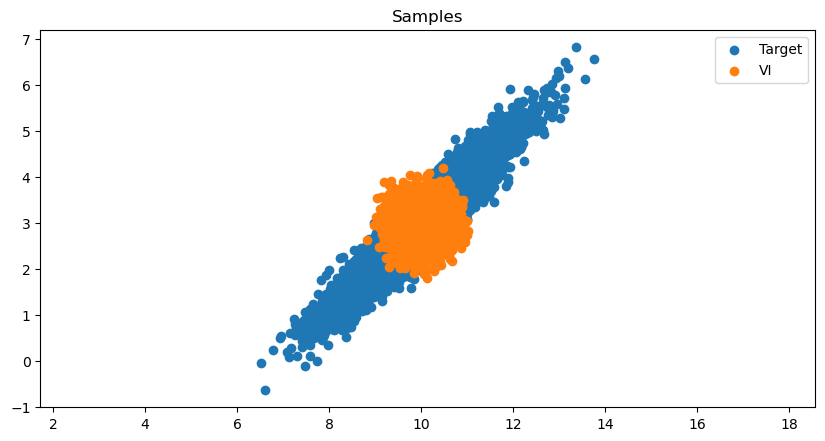

In [10]:
N = 5000

u = std_normal.sample((N, 2)) # это пригодится для reparametrization trick
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
    
samples_target = target.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();

## VI with GMM target

### Target

In [11]:
#### TODO: Добавь VI, таргетом для которого будет смесь двух гауссиан

class GMM():
    '''
    This class defines GMM (Gaussian Mixture Model) target (2d)
    '''
    def __init__(self, mus, covars):
        self.mus = mus
        self.covars = covars
        self.distr = torch.distributions.MixtureSameFamily(mus, covars)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, ))

In [12]:
mix = torch.distributions.Categorical(torch.ones(2,))
comp = torch.distributions.Independent(torch.distributions.Normal(torch.tensor([[-10., 0.],[20.,0.]]), torch.ones(2,2)), 1)

In [13]:
target_gmm = GMM(mix, comp)

In [14]:
target_gmm.get_logdensity(torch.tensor([0.,0.]))

tensor(-52.5310)

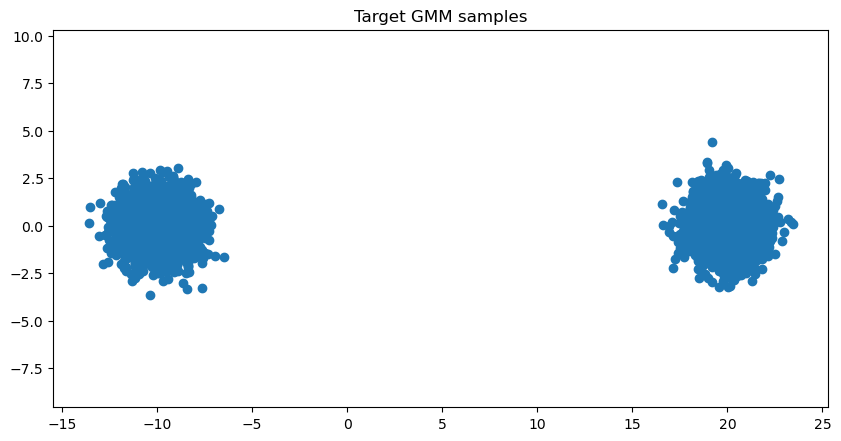

In [15]:
samples = target_gmm.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target GMM samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

### VI model: unimodal Gaussian

In [16]:
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw], lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [17]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2))
    
    std = torch.exp(std_param_raw)
    z = mu_param + u * std
    
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target_gmm.get_logdensity(z).mean()
    
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  2%|█▎                                                                           | 173/10000 [00:00<00:11, 865.23it/s]

Current value of KL at batch number 0 is 50.432857513427734


 11%|████████▎                                                                   | 1090/10000 [00:01<00:09, 905.83it/s]

Current value of KL at batch number 1000 is 3.985743284225464


 22%|████████████████▋                                                           | 2194/10000 [00:02<00:08, 915.08it/s]

Current value of KL at batch number 2000 is 0.7160861492156982


 31%|███████████████████████▋                                                    | 3114/10000 [00:03<00:07, 918.47it/s]

Current value of KL at batch number 3000 is 0.6926960945129395


 41%|███████████████████████████████▏                                            | 4104/10000 [00:04<00:06, 868.05it/s]

Current value of KL at batch number 4000 is 0.693427324295044


 52%|███████████████████████████████████████▏                                    | 5158/10000 [00:05<00:05, 855.19it/s]

Current value of KL at batch number 5000 is 0.6916024684906006


 61%|██████████████████████████████████████████████▌                             | 6130/10000 [00:06<00:04, 862.10it/s]

Current value of KL at batch number 6000 is 0.6930601596832275


 71%|██████████████████████████████████████████████████████▏                     | 7134/10000 [00:08<00:03, 889.70it/s]

Current value of KL at batch number 7000 is 0.693077802658081


 81%|█████████████████████████████████████████████████████████████▊              | 8131/10000 [00:09<00:02, 895.89it/s]

Current value of KL at batch number 8000 is 0.6916532516479492


 91%|█████████████████████████████████████████████████████████████████████       | 9094/10000 [00:10<00:01, 852.62it/s]

Current value of KL at batch number 9000 is 0.6936426162719727


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 881.05it/s]


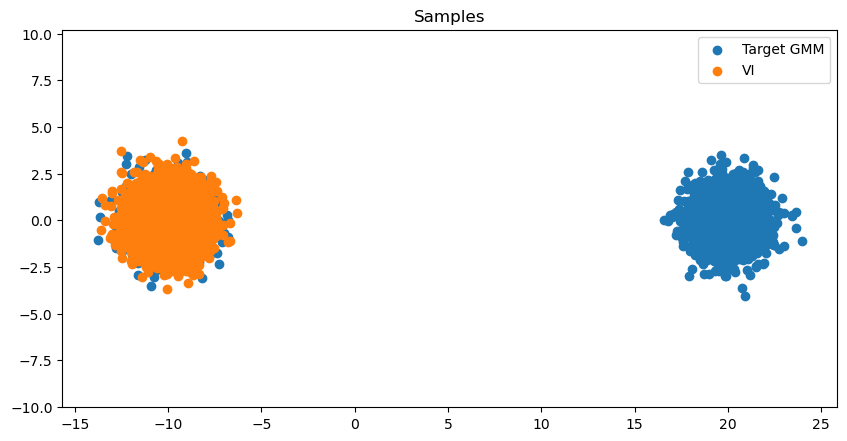

In [18]:
N = 5000

u = std_normal.sample((N, 2))
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std
    
samples_target_gmm = target_gmm.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target_gmm[:, 0], samples_target_gmm[:, 1], label='Target GMM')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();

## Approximating a mixture of Gaussians

In [19]:
mus_param = nn.Parameter(torch.tensor([[0., 0.],[1., 1.]], device=device, dtype=torch.float32))

stds_param_raw = nn.Parameter(torch.tensor([[0., 0.],[0., 0.]], device=device, dtype=torch.float32))

pi_raw = nn.Parameter(torch.tensor(0., device=device, dtype=torch.float32), requires_grad=True)

optimizer = torch.optim.Adam(params=[mus_param, stds_param_raw, pi_raw], lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))
KL_values = []

std_normal1 = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))
std_normal2 = torch.distributions.Normal(loc=torch.tensor(1., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))
#mix = torch.distributions.Categorical(pi)
#comp = torch.distributions.Independent(torch.distributions.Normal(torch.randn(2,2), torch.rand(2,2)), 1)
#std_normal_mix = torch.distributions.MixtureSameFamily(mix, comp)

In [20]:
for i in tqdm(range(num_batches)):
    pi = torch.sigmoid(pi_raw)
    dist = torch.distributions.Bernoulli(probs=pi)
    c = dist.sample((batch_size,1))
       
    std = torch.exp(stds_param_raw)
    #std_normal1 = torch.distributions.Normal(loc=torch.sum(mus_param[0]), scale=torch.sum(std[0]))
    #std_normal2 = torch.distributions.Normal(loc=torch.sum(mus_param[1]), scale=torch.sum(std[1]))
    
    u = std_normal.sample((batch_size, 2))
   
    z = mus_param[1]*(1-c) + mus_param[0]*c + u * (std[1]*(1-c) + std[0]*c) # сэмпл из одной из гауссиан в зависимости от pi
    
    g1 = torch.log(1-pi) + std_normal.log_prob(u).sum(1).mean() - torch.sum(stds_param_raw[0])
    g2 = torch.log(pi) + std_normal.log_prob(u).sum(1).mean() - torch.sum(stds_param_raw[1])
    log_q_components = torch.cat((g1[None], g2[None]), 0)
    
    KL = torch.logsumexp(log_q_components, 0)\
        * (torch.logsumexp(log_q_components, 0) + 1 - target_gmm.get_logdensity(z).mean()).detach()\
        - target_gmm.get_logdensity(z).mean() #- torch.sum(stds_param_raw)
    
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")
        KL_values.append([i, KL.cpu().detach().numpy().item()])

  0%|▎                                                                             | 35/10000 [00:00<00:28, 349.51it/s]

Current value of KL at batch number 0 is -104.20138549804688


 11%|████████                                                                    | 1069/10000 [00:02<00:20, 441.63it/s]

Current value of KL at batch number 1000 is -484.026611328125


 21%|███████████████▌                                                            | 2053/10000 [00:04<00:16, 468.12it/s]

Current value of KL at batch number 2000 is -581.0968627929688


 31%|███████████████████████▍                                                    | 3089/10000 [00:06<00:14, 465.16it/s]

Current value of KL at batch number 3000 is -656.5789184570312


 41%|██████████████████████████████▉                                             | 4072/10000 [00:09<00:13, 455.68it/s]

Current value of KL at batch number 4000 is -780.9293212890625


 51%|██████████████████████████████████████▍                                     | 5057/10000 [00:11<00:10, 461.16it/s]

Current value of KL at batch number 5000 is -1200.420166015625


 61%|██████████████████████████████████████████████▎                             | 6093/10000 [00:13<00:08, 466.30it/s]

Current value of KL at batch number 6000 is -1021.5256958007812


 71%|█████████████████████████████████████████████████████▊                      | 7079/10000 [00:15<00:06, 441.80it/s]

Current value of KL at batch number 7000 is -887.9945678710938


 81%|█████████████████████████████████████████████████████████████▎              | 8069/10000 [00:17<00:04, 463.86it/s]

Current value of KL at batch number 8000 is -764.1620483398438


 91%|█████████████████████████████████████████████████████████████████████▏      | 9104/10000 [00:19<00:01, 465.25it/s]

Current value of KL at batch number 9000 is -1001.5355224609375


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 457.41it/s]


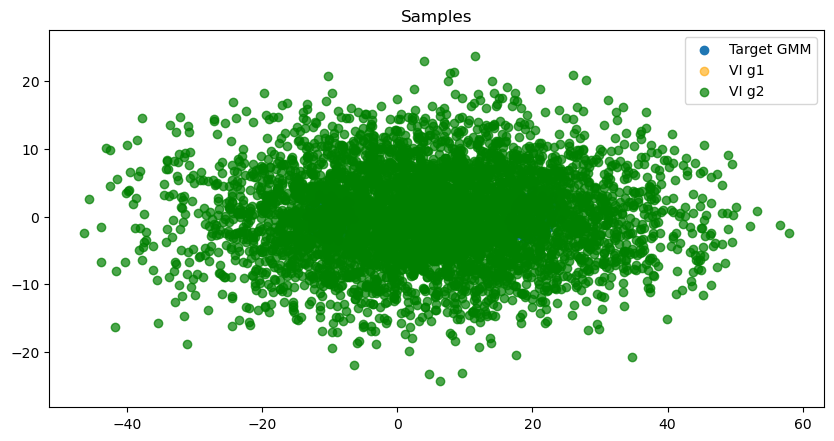

In [21]:
N = 5000

dist = torch.distributions.Bernoulli(probs=torch.sigmoid(pi_raw))
c =  dist.sample((N,1))
c = torch.cat((c,c), dim=1)
#c = torch.cat((c,c), dim=2) # to same dim as u
 
u = std_normal.sample((N,2))

with torch.no_grad():
    std = torch.exp(stds_param_raw)
    sample_varfamily = torch.cat(((mus_param[0] + u * std[0]) * c, (mus_param[1] + u * std[1]) * (1-c)), 1)#(mus_param[0] + u * std[0]) * (1-c) + (mus_param[1] + u * std[1]) * c
    
samples_target_gmm = target_gmm.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target_gmm[:, 0], samples_target_gmm[:, 1], label='Target GMM')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI g1', color='orange', alpha=0.6)
plt.scatter(sample_varfamily[:, 2], sample_varfamily[:, 3], label='VI g2', color='green',alpha=0.7)
#plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI', alpha=0.1)
plt.axis('equal')
plt.legend();

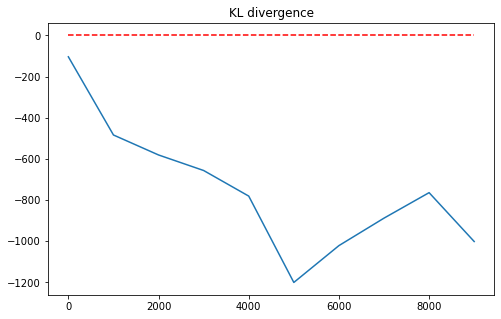

In [22]:
KL_values = np.array(KL_values)
plt.figure(figsize=(8, 5))
plt.title('KL divergence')
plt.plot(KL_values[:,0], KL_values[:,1])
plt.hlines(0, KL_values[:,0][0], KL_values[:,0][-1], color='r', linestyles='--')

In [23]:
pi

tensor(8.7130e-08, grad_fn=<SigmoidBackward>)